dependencies_already_installed: True
choose_strongest_available_device_strategy() - selected strategy type: _DefaultDistributionStrategy
Tue Feb 14 13:25:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+------------------------------

2023-02-14 13:25:11.520393: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 13:25:11.520893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 13:25:11.521752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 13:25:11.522419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

*** Selected 30 train monet photos (shape: (1, 320, 320, 3)) ***


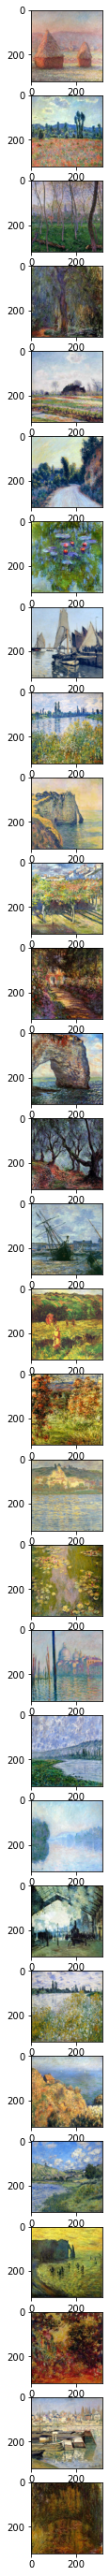



*** running_on_tpu - False ***


Epoch 1/40


2023-02-14 13:25:25.907359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


30/30 [==============================] - 26s 417ms/step - monet_gen_loss: 10.1552 - photo_gen_loss: 10.1233 - monet_disc_loss: 0.8166 - photo_disc_loss: 0.9953
Epoch 2/40
30/30 [==============================] - 12s 415ms/step - monet_gen_loss: 6.6060 - photo_gen_loss: 5.5925 - monet_disc_loss: 0.9895 - photo_disc_loss: 0.7225
Epoch 3/40
30/30 [==============================] - 12s 416ms/step - monet_gen_loss: 6.0648 - photo_gen_loss: 5.1303 - monet_disc_loss: 1.0430 - photo_disc_loss: 0.7892
Epoch 4/40
30/30 [==============================] - 12s 416ms/step - monet_gen_loss: 3.9620 - photo_gen_loss: 3.8747 - monet_disc_loss: 0.7295 - photo_disc_loss: 0.7266
Epoch 5/40
30/30 [==============================] - 12s 417ms/step - monet_gen_loss: 3.6060 - photo_gen_loss: 3.3730 - monet_disc_loss: 0.6988 - photo_disc_loss: 0.6936
Epoch 6/40
13/30 [============>.................] - ETA: 7s - monet_gen_loss: 3.4546 - photo_gen_loss: 3.5495 - monet_disc_loss: 0.6858 - photo_disc_loss: 0.6955

KeyboardInterrupt: 

In [5]:
# Requirements
##Installs
def check_dependencies_already_installed() -> bool:
    try:
        import tensorflow_addons
        return True
    except ImportError:
        return False


def install_dependencies():
    !pip install 'tensorflow_addons' 'tensorflow-determinism' 'gdown'


dependencies_already_installed = check_dependencies_already_installed()
print(f'dependencies_already_installed: {dependencies_already_installed}')
if not dependencies_already_installed:
    install_dependencies()

##Imports
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.data.ops.dataset_ops import Dataset
from tensorflow.python.distribute.tpu_strategy import TPUStrategy
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from datetime import datetime
from zipfile import ZipFile


# Environment setup
##Set tensorflow deterministic mode
def set_tf_deterministic_mode():
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


##Set random seed
def set_training_random_seed(seed: int):
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f'set_training_random_seed() - seed value: {seed}')


##Connect to strongest available device
set_tf_deterministic_mode()


def choose_strongest_available_device_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        selected_strategy = TPUStrategy(tpu)
    except:
        selected_strategy = tf.distribute.get_strategy()

    print(f"choose_strongest_available_device_strategy() - selected strategy type: {type(selected_strategy).__name__}")

    # todo itay - delete this section so it won't mess up in google colab
    gpu_is_available = any(tf.config.list_physical_devices('GPU'))
    if gpu_is_available:
        !nvidia -smi

    return selected_strategy


DEVICE_STRATEGY = choose_strongest_available_device_strategy()

# todo itay - delete
assert tf.__version__ == '2.6.4'

##Download competition dataset
LOCAL_DATASET_FOLDER_PATH = Path('./train_data/gan-getting-started/')


def download_competition_dataset_if_not_present():
    dataset_already_downloaded = LOCAL_DATASET_FOLDER_PATH.exists()
    print(f"dataset_already_downloaded: {dataset_already_downloaded}")
    if not dataset_already_downloaded:
        # note - this is the untouched competition dataset. just uploaded it to the drive so it'll be
        # available via colab as well.
        !gdown '1ZwcoO11NKhYsbuM7hzdSzKjGOnOx6X94'
        !mkdir -p {LOCAL_DATASET_FOLDER_PATH}
        !unzip -o -q ./gan-getting-started.zip -d {LOCAL_DATASET_FOLDER_PATH}


download_competition_dataset_if_not_present()


def _choose_30_images(
        original_monet_dataset: Dataset, choose_30_images_strategy: dict, experiment_random_seed: int
) -> Dataset:
    method = choose_30_images_strategy['method']
    selection_random_seed = choose_30_images_strategy['random_seed']
    method_func_params = choose_30_images_strategy.get('params', None)

    np.random.seed(selection_random_seed)
    try:
        if method == 'random_selection':
            chosen_30_monet_dataset = _pick_random_images(
                original_monet_ds=original_monet_dataset,
                images_count=30
            )
        elif method == 'pick_images_farthest_from_each_other':
            chosen_30_monet_dataset = _pick_images_farthest_from_each_other(
                original_monet_ds=original_monet_dataset,
                images_count=30
            )
        else:
            raise NotImplementedError(f"unknown method - '{method}'")

        images_shape = list(chosen_30_monet_dataset)[0].shape
        print(f'*** Selected 30 train monet photos (shape: {images_shape}) ***')
        _, ax = plt.subplots(30, 1, figsize=(50, 50))
        for i, img in enumerate(chosen_30_monet_dataset):
            img = (img * 127.5 + 127.5).numpy()[0].astype(np.uint8)

            ax[i].imshow(img)
        plt.show()

    finally:
        np.random.seed(experiment_random_seed)
    return chosen_30_monet_dataset


# Load competition dataset
##Load full dataset
def find_competition_dataset_files(local_dataset_folder_path: Path):
    if isinstance(DEVICE_STRATEGY, TPUStrategy):
        from kaggle_datasets import KaggleDatasets
        dataset_folder_path = Path(KaggleDatasets().get_gcs_path())
    else:
        dataset_folder_path = local_dataset_folder_path

    monet_dataset_files = tf.io.gfile.glob(str(dataset_folder_path / 'monet_tfrec/*.tfrec'))
    photo_dataset_files = tf.io.gfile.glob(str(dataset_folder_path / 'photo_tfrec/*.tfrec'))
    assert any(monet_dataset_files)
    assert any(photo_dataset_files)
    print(f"found {len(monet_dataset_files)} monet and {len(photo_dataset_files)} photo tfrec files.")

    return monet_dataset_files, photo_dataset_files


def load_tf_records_dataset(tf_record_files) -> Dataset:
    def _read_and_normalize_tfrecord(record):
        tfrecord_format = {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.string)
        }
        record = tf.io.parse_single_example(record, tfrecord_format)
        image = record['image']
        image = tf.image.decode_jpeg(image, channels=3)
        # print(f'asdsadsad: {(image.shape, type(image))}')
        # image = tf.keras.utils.array_to_img(image)
        # image = image.resize((320, 320))
        # image = np.array(image)
        # image = tf.convert_to_tensor(image)
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        image = tf.reshape(image, [256, 256, 3])
        image = tf.image.resize(image, (320, 320), method='bilinear')
        return image

    sorted_tf_record_files = sorted(tf_record_files)
    dataset = tf.data.TFRecordDataset(sorted_tf_record_files)
    dataset = dataset.map(_read_and_normalize_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


##Pick 30 train monet images strategies
def _pick_images_farthest_from_each_other(original_monet_ds: Dataset, images_count: int) -> Dataset:
    def _images_distance(im1, im2):
        distance = np.sum((im1.numpy().flatten() - im2.numpy().flatten()) ** 2)
        return distance

    farthest_images_list = _incremental_farthest_search(
        list(original_monet_ds), k=images_count, distance_func=_images_distance
    )
    farthest_images_dataset = Dataset.from_tensor_slices(farthest_images_list)
    return farthest_images_dataset


def _pick_random_images(original_monet_ds: Dataset, images_count: int) -> Dataset:
    monet_images_list = list(original_monet_ds)
    ret_dataset = Dataset.from_tensor_slices([
        monet_images_list[image_idx] for image_idx in
        np.random.choice(
            list(range(len(monet_images_list))), size=images_count, replace=False
        )
    ])
    return ret_dataset


def _incremental_farthest_search(array, k: int, distance_func):
    remaining_points = array[:]
    solution_set = [remaining_points.pop(random.randint(0, len(remaining_points) - 1))]

    for _ in tqdm(list(range(k - 1)), desc='incremental_farthest_search() main loop'):
        distances = [distance_func(p, solution_set[0]) for p in remaining_points]
        for i, p in enumerate(remaining_points):
            for j, s in enumerate(solution_set):
                distances[i] = min(distances[i], distance_func(p, s))
        solution_set.append(remaining_points.pop(distances.index(max(distances))))
    return solution_set


def down_sample(filters, size, strides=2, padding='same'):
    initializer = tf.random_normal_initializer(0., 0.02)

    network = keras.Sequential()
    network.add(layers.Conv2D(filters, size, strides=strides, padding=padding,
                              kernel_initializer=initializer, use_bias=False))

    network.add(layers.LeakyReLU())

    return network


def up_sample(filters, size, strides=2, padding='same', apply_dropout=False):
    network = keras.Sequential()
    network.add(layers.Conv2DTranspose(
        filters, size, strides=strides, padding=padding, use_bias=False,
        kernel_initializer=tf.random_normal_initializer(0., 0.02)
    ))
    if apply_dropout:
        network.add(layers.Dropout(0.5))
    network.add(layers.ReLU())
    return network


def build_generator_model():
    inputs = layers.Input(shape=[320, 320, 3])

    # bs = batch size
    down_stack = [
        down_sample(64, 4),  # (bs, 160, 160, 64)
        down_sample(128, 4),  # (bs, 80, 80, 128)
        down_sample(256, 4),  # (bs, 40, 40, 256)
        down_sample(512, 4),  # (bs, 20, 20, 512)
        down_sample(512, 4),  # (bs, 10, 10, 512)
        down_sample(512, 4),  # (bs, 5, 5, 512)
        down_sample(512, 4, strides=1, padding='valid'),  # (bs, 2, 2, 512)
        down_sample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        up_sample(512, 4, strides=1, padding='valid', apply_dropout=True),  # (bs, 5, 5, 1024)
        up_sample(512, 4, apply_dropout=True),  # (bs, 10, 10, 1024)
        up_sample(512, 4),  # (bs, 20, 20, 1024)
        up_sample(256, 4),  # (bs, 40, 40, 512)
        up_sample(128, 4),  # (bs, 80, 80, 256)
        up_sample(64, 4),  # (bs, 160, 160, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 320, 320, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    generator_model = keras.Model(inputs=inputs, outputs=x)
    return generator_model


"""# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.
"""


def build_discriminator_model():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[320, 320, 3], name='input_image')

    x = inp
    down1 = down_sample(64, 5)(x)  # (bs, 160, 160, 64)
    down2 = down_sample(128, 4)(down1)  # (bs, 80, 80, 128)
    down3 = down_sample(256, 3)(down2)  # (bs, 40, 40, 256)
    down4 = down_sample(256, 2)(down3)  # (bs, 20, 20, 256)

    zero_pad1 = layers.ZeroPadding2D()(down4)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    leaky_relu = layers.LeakyReLU()(conv)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    discriminator_model = tf.keras.Model(inputs=inp, outputs=last)
    return discriminator_model


class CycleGan(keras.Model):
    def __init__(
            self,
            monet_generator,
            photo_generator,
            monet_discriminator,
            photo_discriminator,
            lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
            self,
            m_gen_optimizer,
            p_gen_optimizer,
            m_disc_optimizer,
            p_disc_optimizer,
            gen_loss_fn,
            disc_loss_fn,
            cycle_loss_fn,
            identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(
                real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet,
                                                                                             self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo,
                                                                                             self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


"""# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.
"""

"""# Create submission file"""
CREATE_PREDICTIONS = True


def create_predictions_for_kaggle_submission(monet_generator: tf.keras.Model, photo_dataset: Dataset):
    wip_images_folder = Path(f"/tmp/wip_{datetime.now().strftime('%y_%m_%d__%H_%M_%S')}/")
    wip_images_folder.mkdir(parents=True, exist_ok=True)
    output_zip_path = Path('/kaggle/working/images.zip')
    if output_zip_path.exists():
        output_zip_path.unlink()

    with ZipFile(output_zip_path, 'w') as output_images_zip, \
            tqdm(total=7_038, desc='generating prediction images for kaggle submission') as pbar:
        for i, img in enumerate(photo_dataset):
            prediction = monet_generator(img, training=False)[0]
            prediction = tf.image.resize(prediction, (256, 256), method='bilinear')
            prediction = prediction.numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            im = Image.fromarray(prediction)
            wip_image_file_path = wip_images_folder / f'{i + 1}.jpg'
            im.save(wip_image_file_path)
            output_images_zip.write(filename=wip_image_file_path, arcname=wip_image_file_path.name)
            wip_image_file_path.unlink()
            pbar.update()


def experiment_flow(
        choose_30_images_strategy: dict,
        train_settings: dict,
        experiment_random_seed: int,
        create_kaggle_predictions_for_submission: bool = False,
):
    set_training_random_seed(experiment_random_seed)

    monet_dataset_files, photo_dataset_files = find_competition_dataset_files(LOCAL_DATASET_FOLDER_PATH)
    original_monet_dataset = load_tf_records_dataset(monet_dataset_files).batch(1)
    photo_dataset = load_tf_records_dataset(photo_dataset_files).batch(1)

    chosen_30_monet_dataset = _choose_30_images(original_monet_dataset, choose_30_images_strategy,
                                                experiment_random_seed)

    with DEVICE_STRATEGY.scope():
        monet_generator = build_generator_model()  # transforms photos to Monet-esque paintings
        photo_generator = build_generator_model()  # transforms Monet paintings to be more like photos

        monet_discriminator = build_discriminator_model()  # differentiates real Monet paintings and generated Monet paintings
        photo_discriminator = build_discriminator_model()  # differentiates real photos and generated photos

    with DEVICE_STRATEGY.scope():
        def discriminator_loss(real, generated):
            real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
                tf.ones_like(real), real)

            generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                                reduction=tf.keras.losses.Reduction.NONE)(
                tf.zeros_like(generated), generated)

            total_disc_loss = real_loss + generated_loss

            return total_disc_loss * 0.5

    """The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss."""

    with DEVICE_STRATEGY.scope():
        def generator_loss(generated):
            return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
                tf.ones_like(generated), generated)

    """We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference."""

    with DEVICE_STRATEGY.scope():
        def calc_cycle_loss(real_image, cycled_image, lambda_):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return lambda_ * loss1

    """The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator."""

    with DEVICE_STRATEGY.scope():
        def identity_loss(real_image, same_image, lambda_):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return lambda_ * 0.5 * loss

    """# Train the CycleGAN

    Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.
    """

    with DEVICE_STRATEGY.scope():
        optimizer_builder = train_settings['optimizer_builder']
        monet_generator_optimizer = optimizer_builder()
        photo_generator_optimizer = optimizer_builder()

        monet_discriminator_optimizer = optimizer_builder()
        photo_discriminator_optimizer = optimizer_builder()

    with DEVICE_STRATEGY.scope():
        cycle_gan_model = CycleGan(
            monet_generator, photo_generator, monet_discriminator, photo_discriminator
        )

        cycle_gan_model.compile(
            m_gen_optimizer=monet_generator_optimizer,
            p_gen_optimizer=photo_generator_optimizer,
            m_disc_optimizer=monet_discriminator_optimizer,
            p_disc_optimizer=photo_discriminator_optimizer,
            gen_loss_fn=generator_loss,
            disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss,
            identity_loss_fn=identity_loss
        )

    print(f'\n\n*** running_on_tpu - {isinstance(DEVICE_STRATEGY, TPUStrategy)} ***\n\n')

    cycle_gan_model.fit(
        tf.data.Dataset.zip((chosen_30_monet_dataset, photo_dataset)),
        epochs=train_settings['train_epochs']
    )

    print('*** Show trained model predictions sample ***')
    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i, img in enumerate(photo_dataset.take(5)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

    if create_kaggle_predictions_for_submission:
        create_predictions_for_kaggle_submission(monet_generator, photo_dataset)


experiment_flow(
    choose_30_images_strategy=dict(
        method='random_selection',
        random_seed=42
    ),
    train_settings=dict(
        train_epochs=40,
        optimizer_builder=lambda: tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001)
    ),
    experiment_random_seed=1,
    create_kaggle_predictions_for_submission=True
)
